In [1]:
!pip3 install seaborn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [2]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as weight_init
from torch.utils.data import Dataset, DataLoader
import copy
import os
import math
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
# import ipdb

from tqdm import tqdm
import datetime

# LSTM Dataloader

In [3]:
class LibriSamples(torch.utils.data.Dataset):

    def __init__(self, data, lookback_period, prediction_period):
        
        self.training_period = data.shape[0]
        self.lookback_period = lookback_period
        self.prediction_period = prediction_period

        historical = []
        label_close = []
        
        # use data look back n days to predict data in theiode next m days
        # historical: (245, 5, 4) (data_size/batch_size, seq_len, input_size/# features)
        # label_close: (245, 5, 1) (data_size/batch_size, seq_len, input_size/# features)
        for day in range(self.training_period - lookback_period - prediction_period + 1):
            historical.append(data[day:day + lookback_period, :])
            label_close.append(data[day + lookback_period:day + lookback_period + prediction_period, 3:4])
        
        self.historical = np.array(historical, dtype="float32")
        self.label_close = np.array(label_close, dtype="float32")
    
    def __len__(self):
        return self.training_period - self.lookback_period - self.prediction_period + 1

    def __getitem__(self, ind):
        return torch.from_numpy(self.historical[ind, :, :]), torch.from_numpy(self.label_close[ind, :, :])

In [4]:
class TestLibriSamples(torch.utils.data.Dataset):

    def __init__(self, data, lookback_period):
        
        self.training_period = data.shape[0]
        self.lookback_period = lookback_period

        historical = []

        for day in range(self.training_period - lookback_period + 1):
            historical.append(data[day:day + lookback_period, :])

        self.historical = np.array(historical, dtype="float32")

    def __len__(self):
        return self.training_period - self.lookback_period + 1

    def __getitem__(self, ind):
        return torch.from_numpy(self.historical[ind, :, :])

# LSTM Network

In [5]:
class LSTMNetwork(nn.Module):
    def __init__(self, n_features):  # input shape: B, T, C
        super(LSTMNetwork, self).__init__()

        self.lstm = nn.LSTM(input_size=n_features, hidden_size=256, batch_first=True, bias=True, num_layers=3, dropout=0.1)
        self.dropout = nn.Dropout(0.1)
        
        self.classification1 = nn.Linear(256, 128)
        self.classification2 = nn.Linear(128, 1)

    def forward(self, x):
        out1, (out2, out3) = self.lstm(x)

        out = self.classification1(out1)
        out = self.dropout(out)
        out = self.classification2(out)

        return out

# load data
# change csv as necessary, e.g., 'AMZN.csv' is for analyzing Amazon's stock
raw_data = pd.read_csv('AAPL.csv')
n_features = len(raw_data.columns) - 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTMNetwork(n_features).to(device)
print(model)

LSTMNetwork(
  (lstm): LSTM(5, 256, num_layers=3, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (classification1): Linear(in_features=256, out_features=128, bias=True)
  (classification2): Linear(in_features=128, out_features=1, bias=True)
)


# LSTM Train Setup

In [6]:
# parameters
batch_size = 64
lookback_period = 5
prediction_period = 5

# min-max normalization for data pre-processing
combined_raw_data = raw_data
closed_max = combined_raw_data['Adj Close'].max()
closed_min = combined_raw_data['Adj Close'].min()
combined_scaled_data = combined_raw_data.iloc[:, 1:].apply(lambda x : (x - min(x)) / (max(x) - min(x)))

# range choices for train-test split
start = int(len(combined_scaled_data) * 0.4)
end = int(len(combined_scaled_data) * 0.1)

# Train Data Loading
train_data = LibriSamples(combined_scaled_data.values[:-end, :-3], lookback_period, prediction_period)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_loader_no_shuffle = DataLoader(train_data, batch_size=batch_size, shuffle=False)

# Validation Data Loading
val_data = TestLibriSamples(combined_scaled_data.values[-end:, :-3], lookback_period)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                         shuffle=False)

In [7]:
# test train loader
print(len(train_loader))
for i, data in enumerate(train_loader):
    x, y = data
    print(x.shape)
    print(y.shape)
    break

72
torch.Size([64, 5, 5])
torch.Size([64, 5, 1])


In [8]:
# test validation loader
print(len(val_loader))
for i, data in enumerate(val_loader):
    x = data
    print(x)
    break

8
tensor([[[0.3227, 0.3376, 0.3262, 0.3342, 0.0745],
         [0.3424, 0.3521, 0.3401, 0.3324, 0.0793],
         [0.3366, 0.3527, 0.3430, 0.3499, 0.0638],
         [0.3452, 0.3488, 0.3440, 0.3354, 0.0495],
         [0.3424, 0.3483, 0.3473, 0.3450, 0.0386]],

        [[0.3424, 0.3521, 0.3401, 0.3324, 0.0793],
         [0.3366, 0.3527, 0.3430, 0.3499, 0.0638],
         [0.3452, 0.3488, 0.3440, 0.3354, 0.0495],
         [0.3424, 0.3483, 0.3473, 0.3450, 0.0386],
         [0.3491, 0.3579, 0.3509, 0.3443, 0.0473]],

        [[0.3366, 0.3527, 0.3430, 0.3499, 0.0638],
         [0.3452, 0.3488, 0.3440, 0.3354, 0.0495],
         [0.3424, 0.3483, 0.3473, 0.3450, 0.0386],
         [0.3491, 0.3579, 0.3509, 0.3443, 0.0473],
         [0.3366, 0.3390, 0.3329, 0.3261, 0.0411]],

        ...,

        [[0.4848, 0.4866, 0.4811, 0.4752, 0.0675],
         [0.4803, 0.4906, 0.4895, 0.4876, 0.0288],
         [0.4976, 0.5082, 0.5050, 0.4980, 0.0518],
         [0.4990, 0.5033, 0.4998, 0.4892, 0.0460],
         

In [9]:
# training settings for LSTM-training
epochs = 20
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00015)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
scaler = torch.cuda.amp.GradScaler()

# LSTM Train

In [10]:
# training the LSTM
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = data
        x = x.to(device)
        y = y.to(device)

        with torch.cuda.amp.autocast():
            output = model(x)  # output-shape: (B, T, C)
            loss = criterion(output, y)
        total_loss += float(loss)

        scaler.scale(loss).backward() 
        scaler.step(optimizer)
        scheduler.step()
        scaler.update()
    print("Epoch {}/{}, Train Loss {:.04f}".format(epoch + 1, epochs, float(total_loss / len(train_loader))))

Epoch 1/20, Train Loss 0.0090
Epoch 2/20, Train Loss 0.0033
Epoch 3/20, Train Loss 0.0015
Epoch 4/20, Train Loss 0.0006
Epoch 5/20, Train Loss 0.0003
Epoch 6/20, Train Loss 0.0002
Epoch 7/20, Train Loss 0.0001
Epoch 8/20, Train Loss 0.0001
Epoch 9/20, Train Loss 0.0001
Epoch 10/20, Train Loss 0.0001
Epoch 11/20, Train Loss 0.0001
Epoch 12/20, Train Loss 0.0001
Epoch 13/20, Train Loss 0.0001
Epoch 14/20, Train Loss 0.0001
Epoch 15/20, Train Loss 0.0001
Epoch 16/20, Train Loss 0.0001
Epoch 17/20, Train Loss 0.0001
Epoch 18/20, Train Loss 0.0001
Epoch 19/20, Train Loss 0.0001
Epoch 20/20, Train Loss 0.0001


In [11]:
# generate train predictions in a non-shuffle manner
model.eval()
train_result = []
for i, data in enumerate(train_loader_no_shuffle):
    x, _ = data
    x = x.to(device)

    with torch.no_grad():
        output = model(x)  # output-shape: (B, T, C)

    output = output.detach().cpu().numpy()
    output = [out.mean() for out in output]
    train_result.append(output)

In [12]:
# revert min-max normalization for train predictions
flat_result_train = [item for sublist in train_result for item in sublist]
print(flat_result_train[-1])

0.35833806


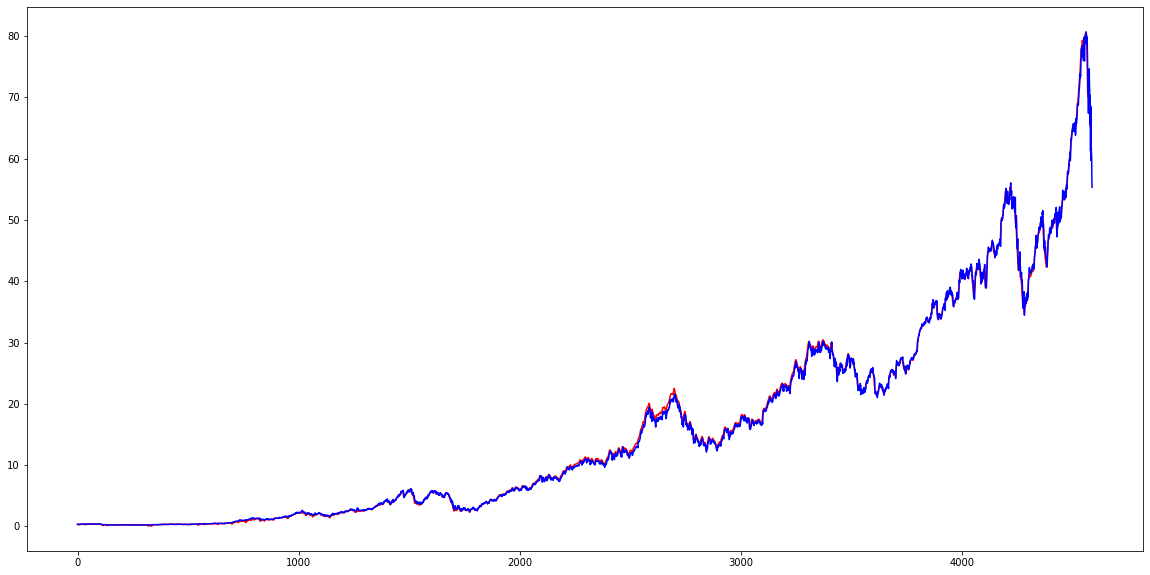

In [13]:
# plot the actual and predicted training data
import matplotlib.pyplot as plt
inversed_result_train = [(price * (closed_max - closed_min) + closed_min) for price in flat_result_train]
actual_price = combined_raw_data['Adj Close'].values[:-end].tolist()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(inversed_result_train[:], 'r', label='pred')
plt.plot(actual_price, 'b', label='actual')
plt.show()

In [14]:
# generate validation predictions
model.eval()
result = []
for i, data in enumerate(val_loader, 0):
    x = data
    x = x.to(device)
    # print(x)
    with torch.no_grad():
        output = model(x)
        output = output.cpu().numpy()
        output = [out.mean() for out in output]
        result.append(output)

In [15]:
# revert min-max normalization for validation predictions
flat_result_val = [item for sublist in result for item in sublist]
print(flat_result_val[-1])

1.0384881


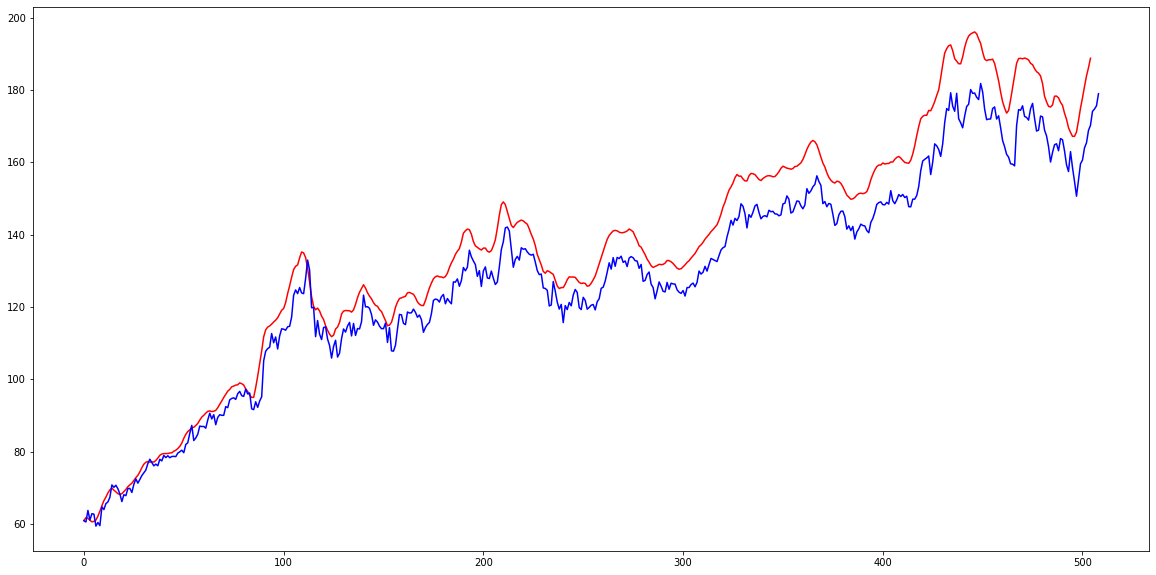

In [16]:
# plot the actual and predicted validation data
inversed_result_val = [(price * (closed_max - closed_min) + closed_min) for price in flat_result_val]
actual_price = combined_raw_data['Adj Close'].values[-end:].tolist()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(inversed_result_val[:], 'r', label='pred')
plt.plot(actual_price, 'b', label='actual')
plt.show()

# Padding and Appending LSTM Results to Dataframe

In [17]:
# padding LSTM results with 0 
# Since LSTM uses past n days of data to predict the future, the LSTM results
# hence cannot match with the first and last couple days of the data
padded_inversed_result_train = np.pad(inversed_result_train, (4, 5), constant_values=0)
padded_flat_result_train = np.pad(flat_result_train, (4, 5), constant_values=0)

padded_inversed_result_val = np.pad(inversed_result_val, (4, 0), constant_values=0)
padded_flat_result_val = np.pad(flat_result_val, (4, 0), constant_values=0)

In [18]:
combined_raw_data['LSTM Result'] = np.concatenate((padded_inversed_result_train, padded_inversed_result_val))
combined_scaled_data['LSTM Result'] = np.concatenate((padded_flat_result_train, padded_flat_result_val))

In [19]:
# Replace padded 0 values with Adj Close
combined_raw_data['LSTM Result'] = np.where(combined_raw_data['LSTM Result'] == 0.0, 
                                            combined_raw_data['Adj Close'], 
                                            combined_raw_data['LSTM Result']).astype('float64')
combined_scaled_data['LSTM Result'] = np.where(combined_scaled_data['LSTM Result'] == 0.0, 
                                               combined_scaled_data['Adj Close'], 
                                               combined_scaled_data['LSTM Result']).astype('float64')

# DRL

# DQN Network

In [20]:
class Network(nn.Module):
    def __init__(self, state_size, action_size):
        super(Network, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(state_size, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, 16),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, action_size)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

# Replay Memory

In [21]:
# replay memory for the experience replay
# agent's memory samples will be randomly chosen from the replay memory to train the policy network
# experience replay allows for better gradient descent performance

from collections import namedtuple
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Parameters for DQN

In [22]:
BATCH_SIZE = 64                   
EPSILON = 1.0
EPSILON_MIN = 0.1
EPSILON_DECAY = 30000
GAMMA = 0.4                    
TARGET_REPLACE_ITR = 10 # T                      
MEMORY_CAPACITY = 30000

# DQN Agent

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Agent:
    def __init__(self, state_size):
        self.state_size = state_size # number of previous days * number of features
        self.step = 0
        self.action_size = 3 # buy, sell, hold
        self.memory = ReplayMemory(MEMORY_CAPACITY) 
        self.epsilon = EPSILON
        self.epsilon_min = EPSILON_MIN
        self.epsilon_decay = EPSILON_DECAY
        self.policy_net = Network(state_size, self.action_size).to(device)
        self.target_net = Network(state_size, self.action_size).to(device)
        
        self.target_net.eval() # fix the target net
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=EPISODES)


    def act(self, state, hold_num, is_train=True):
        self.step += 1
        
        # calculate the epsilon threshold
        # epsilon decays as more steps are completed
        eps_threshold = self.epsilon_min + (self.epsilon - self.epsilon_min) * math.exp(-1. * self.step / self.epsilon_decay)
        
        # the agent will randomly select an action in the possiblility of epsilon
        if is_train and np.random.rand() <= eps_threshold:
            action_space = [0, 1, 2]
            return torch.tensor([random.sample(action_space, 1)], device=device)
        
        # the agent will choose action based on the output of the policy net with 1-epsilon possibility
        with torch.no_grad():
            if is_train == False:
                self.policy_net.eval()
            options = self.policy_net(state)
            if is_train:
                self.policy_net.train()

        best_option = options[0]
    
        return options.max(1)[1].view(1, 1)


    def optimize(self, train=True):
        if len(self.memory) < BATCH_SIZE:
            return

        if train:
            self.policy_net.train()
        else:
            self.policy_net.eval()

        transitions = self.memory.sample(BATCH_SIZE)

        batch = Transition(*zip(*transitions))


        # calculate a mask for non-final states & concatenate batches
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])


        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        
        # Compute all next states
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

        # Compute the expected Q values based on the target net
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        
        # Compute Huber loss
        loss = 0
        if train:
            # criterion = nn.MSELoss()
            # loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
            loss = F.smooth_l1_loss(state_action_values.float(), expected_state_action_values.unsqueeze(1).float())
            
            # Optimize the model
            loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()
            self.scheduler.step()
        return loss, float(self.optimizer.param_groups[0]['lr'])

# Parameters for training

# Environment

In [24]:
# Simulation of the real stock environment
class stock:

    def __init__(self, scaled_df, unscaled_df, num_columns, init_money=100000, lookback_period=6, t=0):

        self.n_actions = 3 # [buy, sell, hold]
        self.n_features = lookback_period * num_columns # num of previous days * num of features types
        self.lookback_period = lookback_period 
        self.init_money = init_money # initial money
        
        self.trend = scaled_df.values # normalized stock data
        self.unscaled_trend = unscaled_df.values # prices w/o min-max normalization
        
        self.min_buy_commission = 5  # to allow MIN(min buy commission, vol * buy commission rate)
        self.min_sell_commission = 5
        self.buy_commission_rate = 0.0003
        self.sell_commission_rate = 0.0003 
        self.tax = 0.001 # applied when selling stocks
        
        self.t = t
    
    # reset the environment for each episode
    def reset(self):
        self.hold_money = self.init_money # reset holding money to initial money
        
        self.buy_price = 0                # previous stock buying price
        self.sell_price = 0               # previous stock selling price
        
        self.stock_value = 0              # total market value of stock
        self.total_value = 0              # total stock value + cash
        self.last_value = self.init_money # total value in t-1
        self.hold_num = 0                 # num of stocks currently hold
        self.hold_period = 0              # num of consecutive action 0 has been called
        self.total_profit = 0             # total profits so far
        self.reward = 0                   # reward at current timestamp
        
        self.consecutive_action = 0       # number of consecutive actions called 
        self.pre_action = -1              # action chosen in previous step
        
        # record the timing for each executed actions
        self.time_buy_stock = [] 
        self.time_sell_stock = [] 
        self.time_hold_stock = []
        
        # performance recorder
        self.profit_rate_account = [] 
        self.profit_rate_stock = []
        self.daily_return_account = []
        
        self.t = 0

        return self.get_state(self.t)

    def get_state(self, t):

        day = t - self.lookback_period + 1

        historical = []

        # if the current timestamp < lookback period, pad with the first day data
        if t < self.lookback_period - 1:
            historical = np.concatenate((-(t - self.lookback_period + 1) * [self.trend[0, :]], self.trend[0 : t + 1, :]))
        else:
            historical = self.trend[t - self.lookback_period + 1 : t + 1]
        
        # data at t+1
        if t < self.lookback_period - 2:
            historical2 = np.concatenate((-(t - self.lookback_period + 2) * [self.trend[0, :]], self.trend[0 : t + 2, :]))
        else:
            historical2 = self.trend[t - self.lookback_period + 2 : t + 2]

        historical = (historical2 / (historical + 0.0001) - 1) 
        historical = historical.reshape(1, -1)

        return torch.FloatTensor(historical).to(device) # return states @ time t

    def buy_stock(self):       
        
        # buy stocks in batches of 10 -> if the remaining money cannot buy 10 stocks at once,
        # then the buy action cannot be carried out
        buy_num = (self.hold_money // self.unscaled_trend[self.t] // 10) * 10
        self.buy_price = self.unscaled_trend[self.t]
        
        volume = self.unscaled_trend[self.t] * buy_num # current stock price * trading Q

        commission = max(volume * self.buy_commission_rate, self.min_buy_commission)

        # if the commission cannot be paid, then reduce buying num by 10
        while commission + volume > self.hold_money and buy_num > 0:
            buy_num -= 10
            volume -= 10 * self.unscaled_trend[self.t]
            commission = max(volume * self.buy_commission_rate, self.min_buy_commission)
        
        # if a buy action is executed, update the portfolio
        if buy_num > 0:
            self.hold_num += buy_num
            self.stock_value += volume
            
            # update holding money by lessing stock costs and commission fees
            self.hold_money = self.hold_money - volume - commission 

            self.time_buy_stock.append(self.t) # record the buy action

    def sell_stock(self, sell_num):
        volume = sell_num * self.unscaled_trend[self.t]

        self.sell_price = self.unscaled_trend[self.t]

        commission = max(volume * self.sell_commission_rate, self.min_buy_commission)
        sell_tax = self.tax * volume
        
        # update holding money by adding incomes from stocks and lessing applicable commission and tax
        self.hold_money = self.hold_money + volume - commission - sell_tax
        self.hold_num = 0
        self.stock_value = 0
        self.time_sell_stock.append(self.t)

    def step(self, action):
        # check if the agent repeatedly calls the same action
        if action == self.pre_action:
            self.consecutive_action += 1
        else:
            self.consecutive_action = 0
            self.pre_action = action
        
        # carries out the action
        if action == 1:
            self.buy_stock()
            self.hold_period = 0

        elif action == 2 and self.hold_num > 0:
            self.hold_period = 0
            self.sell_stock(self.hold_num)
        else:
            self.time_hold_stock.append(self.t)
            self.hold_period += 1
        
        # current market value of holding stocks
        self.stock_value = self.unscaled_trend[self.t] * self.hold_num
        
        self.total_value = self.stock_value + self.hold_money   # total portfolio value 
        self.total_profit = self.total_value - self.init_money  # profits above initial funds
        
        # basic reward
        self.reward = (self.total_value / self.last_value - 1)
        self.daily_return_account.append(self.reward)
        
        # scaled reward calculation to encourage "buy-low-sell-high"
        if action == 1 and self.sell_price != 0 and self.hold_num == 0:
            if self.reward > 0:
                self.reward /= (self.sell_price / self.unscaled_trend[self.t])
            else:
                self.reward *= self.sell_price / self.unscaled_trend[self.t]
        elif action == 2 and self.hold_num > 0:
            if self.reward > 0:
                self.reward *= self.unscaled_trend[self.t] / self.buy_price
            else:
                self.reward /= (self.unscaled_trend[self.t] / self.buy_price)
        
        # applies penalties on repeated actions
        if self.consecutive_action > 0:
            if self.pre_action == 1 or self.pre_action == 2:
                if self.reward > 0:
                    self.reward *= 0.25 ** self.consecutive_action
                else:
                    self.reward = self.reward * min(sys.float_info.max / 2, 4 ** self.consecutive_action)
            self.reward -= self.hold_period ** 1.1
        
        self.last_value = self.total_value
        
        self.profit_rate_account.append(self.total_value / self.init_money - 1)
        self.profit_rate_stock.append(self.unscaled_trend[self.t] / self.unscaled_trend[0] - 1)

        self.t = self.t + 1
        s_ = self.get_state(self.t)

        return s_, self.reward, self.t == len(self.trend) - 2
    
    def get_info(self):
        return self.time_sell_stock, self.time_buy_stock, self.time_hold_stock, self.profit_rate_account, self.profit_rate_stock, self.daily_return_account  
    
    def calc_sharpe(self):
        # calculation of sharpe ratio
        daily_return = np.array(self.daily_return_account)
        return np.mean(daily_return) / np.std(daily_return) * (252 ** 0.5)
    
    def draw(self, save_name1, save_name2):

        time_sell_stock, time_buy_stock, time_hold_stock, profit_rate_account, profit_rate_stock, daily_return = self.get_info()
        
        total_gains = self.total_profit   # total gains in dollars
        roi = profit_rate_account[-1]     # final ROI
        sharpe = self.calc_sharpe()       # sharpe ratio

        stock_price = self.unscaled_trend
        fig = plt.figure(figsize = (15,5))
        plt.plot(stock_price, color='r', lw=2.)
        
        # plot buy, sell, (hold) actions by time, on stock's trend
        # uncomment for plotting hold action
        plt.plot(stock_price, '^', label = 'buy action', markevery = time_buy_stock, color='m', markersize=8)
        plt.plot(stock_price, 'v', label = 'sell action', markevery = time_sell_stock, color='k', markersize=8)
        # plt.plot(stock_price, '>', label = 'hold action', markevery = time_hold_stock, color='b', markersize=8)
        
        plt.title('total gains %.2f, ROI %.2f%%, sharpe ratio %.2f'%(total_gains, roi * 100, sharpe))
        plt.legend()
        display(fig)
        plt.savefig(save_name1)
        plt.close()

        fig = plt.figure(figsize = (15,5))
        # plot the stock performance comparisons
        plt.plot(profit_rate_account, label='my account')
        plt.plot(profit_rate_stock, label='stock')
        plt.legend()
        display(fig)
        plt.savefig(save_name2)
        plt.close()

# TRAIN Setup

In [25]:
def game_step(observation, env, step=None, train=True):

    # agent takes action based on observation 
    action = agent.act(observation, env.hold_num, train)

    # after taking the action, observing the next observation and reward
    observation_, reward, done = env.step(action)
    reward = torch.tensor([reward], device=device)
    
    # push memory to replay memory
    if train:
        agent.memory.push(observation, action, reward, observation_)
    loss = 0
    lr = 0
    
    if step and (step >= BATCH_SIZE) and (step % 5 == 0):
        loss, lr = agent.optimize(train)

    # swap observation
    observation = observation_
    
    return observation, done, loss, lr
    

def run(sharpe_matrix, epoch):
    max_profit = -99999999
    best_loss = 99999999
    step = 0

    for episode in range(EPISODES):
        
        # initial observation
        observation = env.reset()
        done = False
        total_loss = 0
        
        while not done:
            observation, done, loss, lr = game_step(observation, env, step=step)
            total_loss += loss
            if not done:
                step += 1
                
        if env.total_profit > max_profit:
            torch.save(agent.policy_net.state_dict(), 'best_model')
            max_profit = env.total_profit
        
        daily_ret = env.daily_return_account
        daily_ret = np.array(daily_ret)
        sharpe = np.mean(daily_ret) / np.std(daily_ret) * (252 ** 0.5)
        
        sharpe_matrix[epoch][episode] = sharpe # for plotting performance graphs over episodes
        
        print('episode:%d, total_profit:%.3f, sharpe:%.3f, loss:%.3f, lr:%.5f' % (episode, env.total_profit, sharpe, total_loss, lr))
        
        if episode % TARGET_REPLACE_ITR == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
    
    return sharpe_matrix

def BackTest():
    # validation
    env_val = stock(combined_scaled_data.iloc[-end:].reset_index(drop=True), 
                    combined_raw_data['Adj Close'].iloc[-end:].reset_index(drop=True), num_col, lookback_period = LOOKBACK_PERIODS)
    observation = env_val.reset()

    agent.policy_net.load_state_dict(torch.load('best_model'))
    while True:
        observation, done, _, _ = game_step(observation, env_val, train=False)
        if done:
            break
    print('total_profit:%.3f' % (env_val.total_profit))
    return env_val

# Train and Validation

episode:0, total_profit:611476.318, sharpe:0.546, loss:511.069, lr:0.00000
episode:1, total_profit:202372.885, sharpe:0.363, loss:722.033, lr:0.00000
episode:2, total_profit:240238.841, sharpe:0.378, loss:1116.807, lr:0.00000
episode:3, total_profit:3882683.855, sharpe:0.830, loss:3609.847, lr:0.00000
episode:4, total_profit:521625.072, sharpe:0.482, loss:6964147712.000, lr:0.00065
total_profit:186662.078


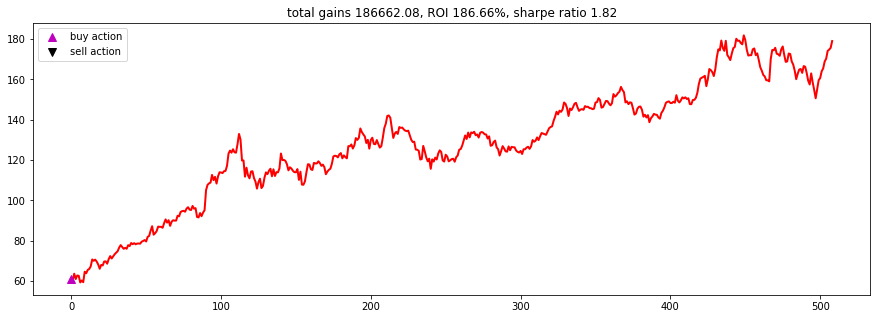

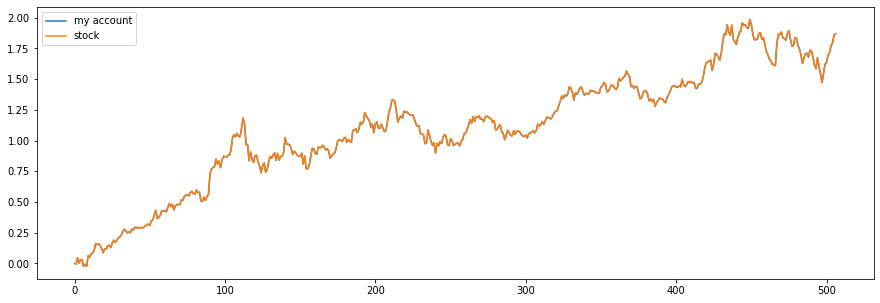

episode:0, total_profit:1253681.753, sharpe:0.693, loss:632.899, lr:0.00000
episode:1, total_profit:1134148.307, sharpe:0.637, loss:10554.937, lr:0.00000
episode:2, total_profit:158298.911, sharpe:0.326, loss:15185.680, lr:0.00000
episode:3, total_profit:3163010.865, sharpe:0.802, loss:16123.980, lr:0.00000
episode:4, total_profit:3399390.609, sharpe:0.797, loss:317585.875, lr:0.00065
total_profit:170143.201


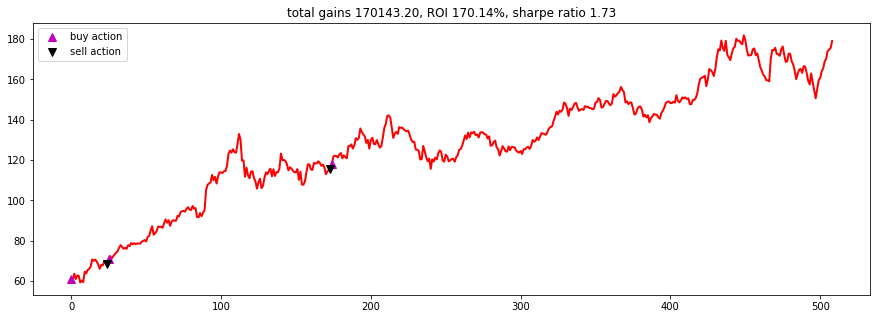

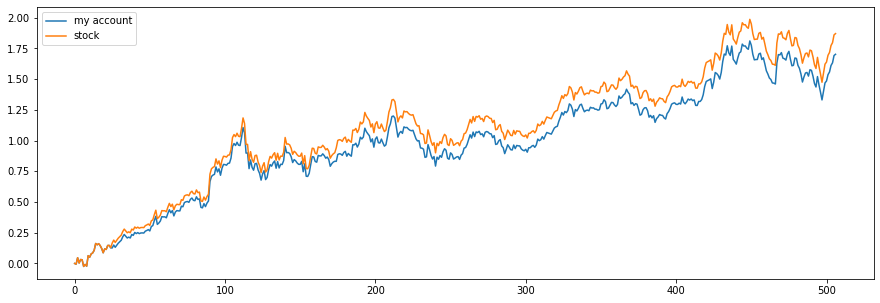

episode:0, total_profit:1373577.831, sharpe:0.721, loss:502.806, lr:0.00000
episode:1, total_profit:1158733.499, sharpe:0.652, loss:711.255, lr:0.00000
episode:2, total_profit:551244.702, sharpe:0.505, loss:1100.350, lr:0.00000
episode:3, total_profit:1393310.574, sharpe:0.654, loss:3049.676, lr:0.00000
episode:4, total_profit:3034272.376, sharpe:0.784, loss:8950.656, lr:0.00065
total_profit:177947.647


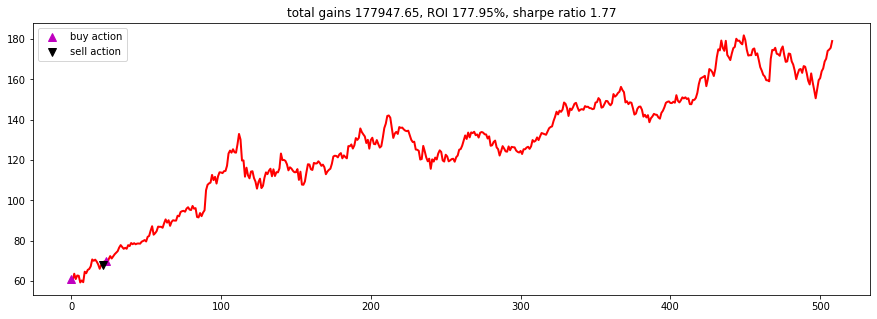

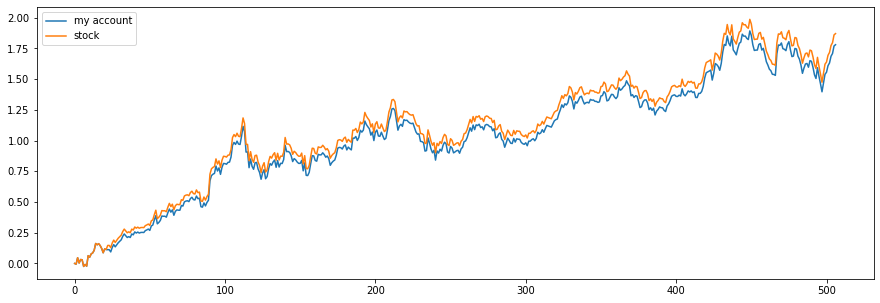

episode:0, total_profit:188303.264, sharpe:0.360, loss:524.698, lr:0.00000
episode:1, total_profit:230039.060, sharpe:0.377, loss:544.119, lr:0.00000
episode:2, total_profit:938917.136, sharpe:0.594, loss:1839.484, lr:0.00000
episode:3, total_profit:1533506.139, sharpe:0.668, loss:64090.449, lr:0.00000
episode:4, total_profit:599631.735, sharpe:0.507, loss:5433832.500, lr:0.00065
total_profit:186662.078


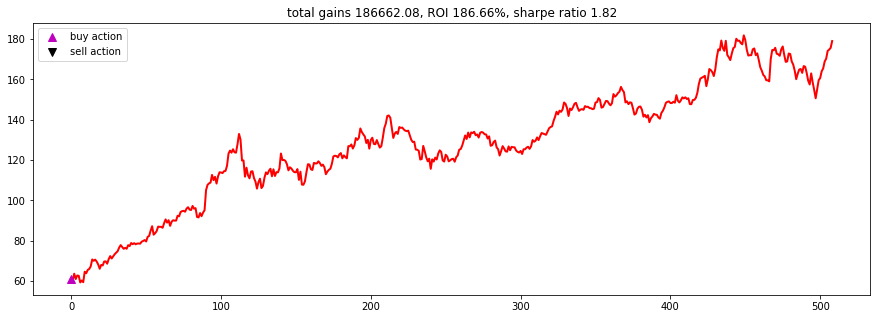

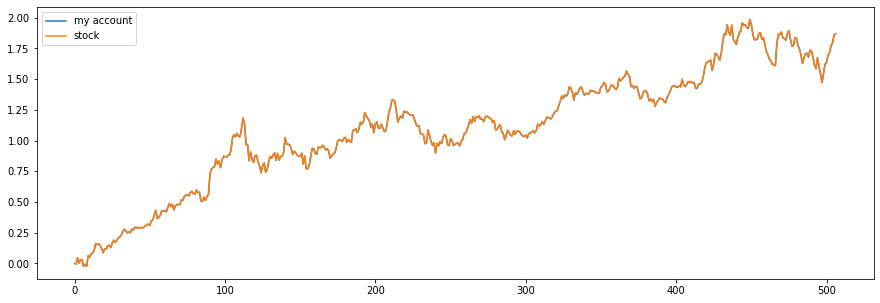

episode:0, total_profit:305427.742, sharpe:0.432, loss:526.627, lr:0.00000
episode:1, total_profit:65329.691, sharpe:0.238, loss:506.776, lr:0.00000
episode:2, total_profit:342070.597, sharpe:0.429, loss:1097.173, lr:0.00000
episode:3, total_profit:699243.366, sharpe:0.535, loss:36258552.000, lr:0.00000
episode:4, total_profit:4381263.532, sharpe:0.835, loss:16209420288.000, lr:0.00065
total_profit:185349.377


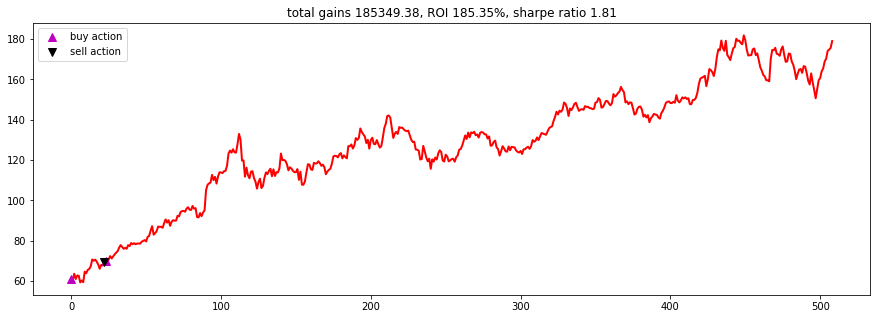

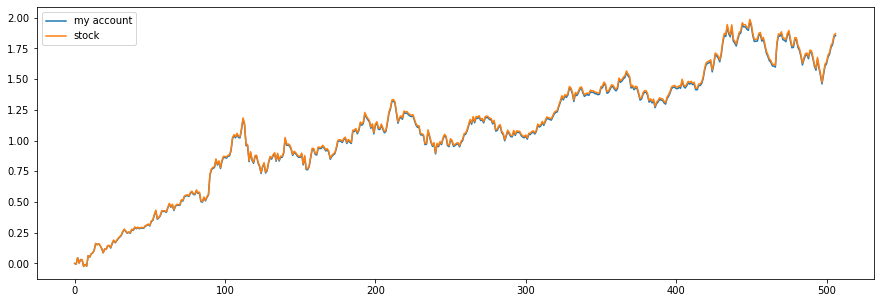

In [26]:
LOOKBACK_PERIODS = 5
EPISODES = 5
EPOCHS = 5

start = int(len(combined_scaled_data) * 0.4)
end = int(len(combined_scaled_data) * 0.1)

roi = []
sharpe = []

sharpe_matrix = np.zeros([EPOCHS, EPISODES])

num_col = len(combined_scaled_data.columns)

for epoch in range(EPOCHS):
    env = stock(combined_scaled_data.iloc[:-end], combined_raw_data['Adj Close'].iloc[:-end], num_col, lookback_period = LOOKBACK_PERIODS)
    agent = Agent(env.n_features)
    sharpe_matrix = run(sharpe_matrix, epoch)
    #env.draw('train_trade.png', 'train_profit.png') # optional: plot for training result
    agent.step
    
    # validation
    env_val = BackTest()
    roi.append(env_val.profit_rate_account[-1]*100)
    sharpe.append(env_val.calc_sharpe())
    env_val.draw('trade1.png', 'profit1.png')

# Performance Evalutaion

In [27]:
print('Average ROI: ', (np.sort(roi)).mean())
print('Average Sharpe Ratio: ', np.sort(sharpe).mean())
print('ROI Stdev: ', np.std(roi))
print('Sharpe Ratio Stdev: ', np.std(sharpe))

Average ROI:  181.35287608540563
Average Sharpe Ratio:  1.7908830936248883
ROI Stdev:  6.474560231932163
Sharpe Ratio Stdev:  0.03383156676050011


In [28]:
# View all ROI & Sharpe Ratio
np.sort(roi), np.sort(sharpe)

(array([170.1432015 , 177.94764681, 185.34937698, 186.66207757,
        186.66207757]),
 array([1.73283982, 1.77184686, 1.81386118, 1.81793381, 1.81793381]))

<AxesSubplot:xlabel='EPISODES', ylabel='SHARPE'>

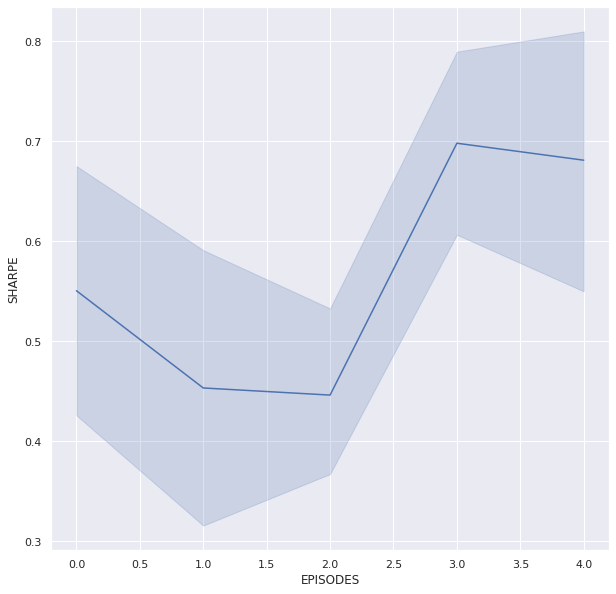

In [36]:
# plot sharpe ratio performance (with error bar) for episodes
# sharpe_matrix: (EPOCH, EPISODE)
sharpe_table = pd.DataFrame(columns=['EPOCHS', 'EPISODES', 'SHARPE'])

for epoch in range(EPOCHS):
    for episo in range(EPISODES):
        row = pd.DataFrame(np.array([epoch, episo, sharpe_matrix[epoch][episo]]).reshape(1, 3), columns=['EPOCHS', 'EPISODES', 'SHARPE'])
        sharpe_table = sharpe_table.append(pd.DataFrame(row, columns=['EPOCHS', 'EPISODES', 'SHARPE']))
sharpe_table['EPOCHS'] = sharpe_table['EPOCHS'].astype('int64', copy=True)
sharpe_table['EPISODES'] = sharpe_table['EPISODES'].astype('int64', copy=True)
sharpe_table = sharpe_table.reset_index(drop=True)
sns.set(rc={'figure.figsize':(10, 10)})
sharpe_plot = sns.lineplot(data=sharpe_table, x='EPISODES', y='SHARPE')
sharpe_plot

# Comparison Metrics

In [ ]:
# calculate performance for buy-and-hold strategy
bh = combined_raw_data['Adj Close'].iloc[-end:].reset_index(drop=True).values
bh_roi = bh[-1] / bh[0] - 1
bh_daily_ret = []
for i in range(len(bh) - 1):
    bh_daily_ret.append(bh[i+1] / bh[i] - 1)
bh_sharpe = np.mean(bh_daily_ret) / np.std(bh_daily_ret) * (252 ** 0.5)

print('Buy-and-Hold ROI:', bh_roi * 100)
print('Buy-and-Hold Sharpe Ratio:', bh_sharpe)

In [ ]:
# calculate performance for short-and-hold strategy
sh = bh
sh_roi = sh[0] / sh[-1] - 1
sh_daily_ret = []
for i in range(len(sh) - 1):
    sh_daily_ret.append(sh[i] / sh[i+1] - 1)
sh_sharpe = np.mean(sh_daily_ret) / np.std(sh_daily_ret) * (252 ** 0.5)

print('Short-and-Hold ROI:', sh_roi * 100)
print('Short-and-Hold Sharpe Ratio:', sh_sharpe)

# Optional: Separate Validation Section

In [ ]:
# allows for running validation individually
env_val = BackTest()

In [ ]:
# draw
env_val.draw('trade1.png', 'profit1.png')

In [ ]:
temp = np.array([[0.9, 0.8, 0.3]])
np.argsort(temp, 1)[0][-1]